## Read Me
Usecase - Financial News Sentiment Analysis Using DistilRoberta
Model Used - DistilRoberta(Hugging Face)

Dataset Used - Phrase Bank Dataset (sentence_75agree - 75% data points validated by the experts)

Preprocessing - For preprocessing we used famous yogawicaksan helper github.

Metric Used : Because the dataset is imbalanced , I would go for confusin matrix and F1 Score. Both will provide an detailed view how the model is
            working on diff labels.Sometime we might get high accuracy to the biased imbalanced dataset but the F1 Score will the tell you the actual
            scenario. So my go to option will be F1 Score and Confusion Matrix. While training Layoutlmv3 model for information extraction documents
            I had used F1 score as I had alost 30 NER to extract , and F1 score gave me an good idea how robust my model is for all the diff labels.

HOW TO RUN THE CODE:
The last cell of this notebook consists API code. 
Copy the code in a separate file named main.py.
Install the dependencies - requirements.txt
Simply run the command - uvicorn main:app --reload

The API can take multiple nested inputs.
Tested the API on 10 unseen data points.Below is the output:


A LOT CAN BE DONE , THIS IS JUST LIKE A QUICK POC , WHICH NEEDS TO PRESENTED TO THE CLIENT :)

## Import the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import wget, gc
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Flatten
import tensorflow as tf
from keras.models import Model
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder

## Load the Dataset from HuggingFace

In [19]:
from datasets import load_dataset
load_data = load_dataset("takala/financial_phrasebank", "sentences_75agree",trust_remote_code=True)
init_data = fin_data['train']
sentences = [example['sentence'] for example in findataset]
labels = [example['label'] for example in findataset]

fin_data = pd.DataFrame({
    'sentence': sentences,
    'label': labels
})

# Display the first few rows of the DataFrame
fin_data.head()

                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  With the new production plant the company woul...      2
2  For the last quarter of 2010 , Componenta 's n...      2
3  In the third quarter of 2010 , net sales incre...      2
4  Operating profit rose to EUR 13.1 mn from EUR ...      2


## Data Exploration

In [22]:
#initial overview of dataset
fin_data.shape

(3453, 2)

In [23]:
#check null values
fin_data.isna().sum()

sentence    0
label       0
dtype: int64

In [27]:
#checking duplicates
print(f"Duplicates before : {fin_data.duplicated().sum()}")

#Drop the duplicates
fin_data = fin_data.drop_duplicates()
print(f"Duplicates after : {fin_data.duplicated().sum()}")

Duplicates before : 5
Duplicates after : 0


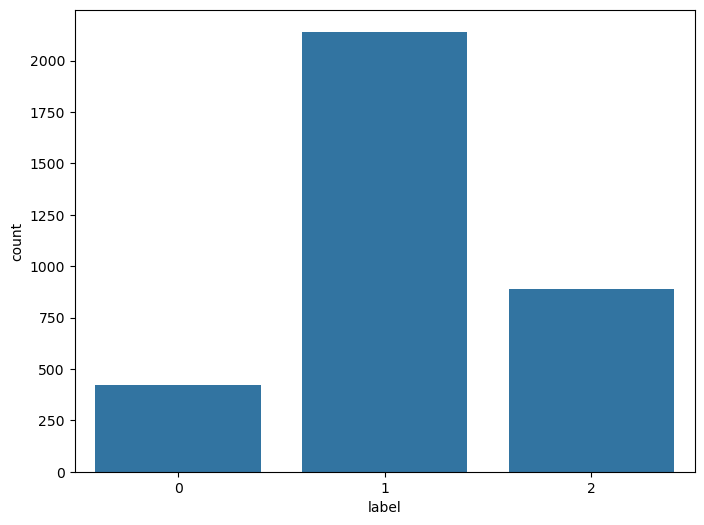

3336

In [32]:
#plot the label column
plt.figure(figsize=(8,6))
fig = sns.countplot(x="label",data=fin_data)
plt.show(fig)
plt.close("all")
del fig
gc.collect()

#NOTE: 0 : Negative , 1 : Neutral , 2 : Positive

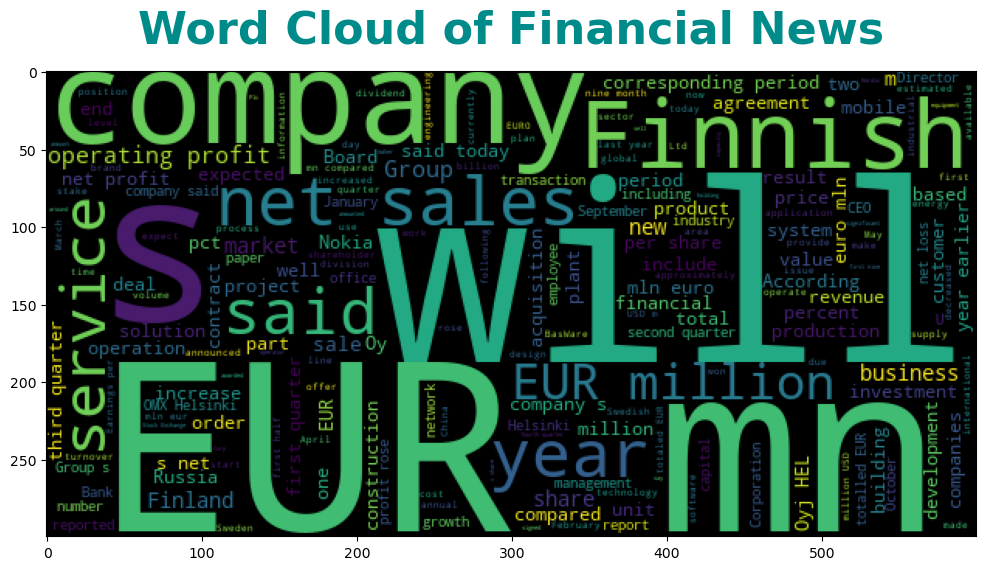

In [35]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(fin_data.sentence))
plt.title('Word Cloud of Financial News',fontsize=32,fontweight='bold',color='darkcyan',pad=20)
plt.imshow(wc);

C:\Users\Vivek Singh Rajput\AppData\Local\Temp\ipykernel_3764\1293274678.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fin_data['num_words']);


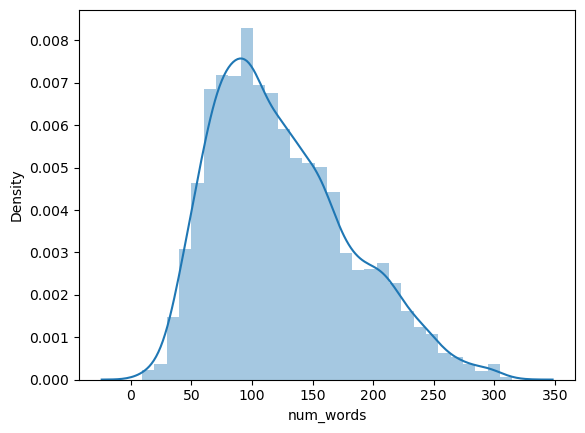

In [37]:
fin_data['num_words'] = fin_data.sentence.apply(len)
sns.distplot(fin_data['num_words']);

In [38]:
#overview w.r.t number of words inthe sentences
fin_data.num_words.describe()

count    3448.000000
mean      124.813805
std        56.310040
min         9.000000
25%        81.000000
50%       116.000000
75%       160.000000
max       315.000000
Name: num_words, dtype: float64

In [39]:
def clean_text(data,col):
    data[col] = data[col].apply(clean_html)
    data[col] = data[col].apply(remove_)
    data[col] = data[col].apply(remove_digits)
    data[col] = data[col].apply(remove_links)
    data[col] = data[col].apply(remove_special_characters)
    data[col] = data[col].apply(removeStopWords)
    data[col] = data[col].apply(punct)
    data[col] = data[col].apply(email_address)
    data[col] = data[col].apply(non_ascii)
    data[col] = data[col].apply(lower)
    return data

In [41]:
processed_data = clean_text(fin_data,"sentence")
processed_data.head()

,sentence,label,num_words
0,according gran company plans move production r...,1,127
1,with new production plant company would increa...,2,206
2,for last quarter componenta s net sales double...,2,193
3,in third quarter net sales increased eur mn op...,2,125
4,operating profit rose eur mn eur mn correspond...,2,122


## Loading model from HuggingFace and Inference.

In [43]:
#split the data
train_df, validation_df = train_test_split(processed_data,test_size=0.25,random_state=101,shuffle=True,stratify=processed_data.label)

In [ ]:
#loading the model
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3,from_pt=True)

In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn import functional as F

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = TFAutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")


def model_infer(text):
# Define the sentence to be analyzed
    # sentence = "Your example sentence here"
    
    # Tokenize the sentence
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    
    # Perform inference with the model
    with torch.no_grad():  # No need to compute gradients
        outputs = model(**inputs)
    
    # Get the logits (raw scores) from the model output
    logits = outputs.logits
    
    # Apply softmax to get probabilities
    # probabilities = F.softmax(logits, dim=-1)
    probabilities = tf.nn.softmax(logits, axis=-1)
    # Get the predicted class index
    predicted_class = tf.argmax(probabilities, axis=-1).numpy()[0]
    
    # Print results
    print(f"Predicted class index: {predicted_class}")
    print(f"Probabilities: {probabilities}")
    return predicted_class, probabilities

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [73]:
text = '''Welcome !'''
print(model_infer(text))

Predicted class index: 1
Probabilities: [[7.1911934e-05 9.9985635e-01 7.1802904e-05]]
(1, <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[7.1911934e-05, 9.9985635e-01, 7.1802904e-05]], dtype=float32)>)


## Exposing to an API - save this code as main.py then run the api uvicorn main:app --reload

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
app = FastAPI()

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = TFAutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Define request body schema
class TextRequest(BaseModel):
    text: str

@app.post("/predict/")
async def predict(request: list[TextRequest]):
    
    results = []
    
    for item in request:
        print("###", item.text)
        text = item.text

        # Tokenize the text
        inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)

        # Perform inference with the model
        outputs = model(inputs)

        # Get the logits (raw scores) from the model output
        logits = outputs.logits

        # Apply softmax to get probabilities
        probabilities = tf.nn.softmax(logits, axis=-1)

        # Get the predicted class index
        predicted_class = tf.argmax(probabilities, axis=-1).numpy()[0]

        if predicted_class == 0:
            prediction = "Negative"
        elif predicted_class == 1:
            prediction = "Neutral"
        else: 
            prediction = "Positive"
            

        # Convert probabilities to a list
        probabilities_list = probabilities.numpy().tolist()[0]
        
        result = {
            "text": text,
            "predicted_class": prediction}
        
        results.append(result)
        # Return results
    return results

In [ ]:
Payload :

[
    {
      "text": "Stocks all time low - Donald Trump"
    },
    {
      "text": "War will have no affect on the stocks - CEO JP Morgan"
    },
    {
      "text": "USA biggest scams creates trouble for NASDAQ - Economists"
    },
    {
      "text" : "The relocation of Ragot has already started and will be completed in the next few weeks , with the Waterqueen and Tortue moves planned for mid-2008 and VMC Europe during the third quarter of 2008 ."
    },
    {
       "text" : "Raffles Equities Ltd became a substantial holder in Archer Exploration Ltd on January 12 with 11.7 million shares ( 18.2 pc ) ."
    },
    {
       "text" : "We will now , after the relevant authority approvals , make a mandatory bid as required by the Finnish Securities Markets Act ."
    },
    {
        "text" : "Post demerger, Adani Wilmar eyes aggressive business expansion"
    },
    {
        "text" : "HDFC Securities joins hands with Vested Finance to offer access to global investing for Indians & NRIs"
    },
    {
        "text" : "India issues travel advisory amid violent clashes in Bangladesh"
    },
    {
        "text" : "Oracle’s Big Shift: Warren Buffett slashes Berkshire Hathaway’s Apple stake by almost 50%, stirs market jitters"
    }

  ]


In [ ]:
Result:

[
  {
    "text": "Stocks all time low - Donald Trump",
    "predicted_class": "Negative"
  },
  {
    "text": "War will have no affect on the stocks - CEO JP Morgan",
    "predicted_class": "Neutral"
  },
  {
    "text": "USA biggest scams creates trouble for NASDAQ - Economists",
    "predicted_class": "Negative"
  },
  {
    "text": "The relocation of Ragot has already started and will be completed in the next few weeks , with the Waterqueen and Tortue moves planned for mid-2008 and VMC Europe during the third quarter of 2008 .",
    "predicted_class": "Neutral"
  },
  {
    "text": "Raffles Equities Ltd became a substantial holder in Archer Exploration Ltd on January 12 with 11.7 million shares ( 18.2 pc ) .",
    "predicted_class": "Neutral"
  },
  {
    "text": "We will now , after the relevant authority approvals , make a mandatory bid as required by the Finnish Securities Markets Act .",
    "predicted_class": "Neutral"
  },
  {
    "text": "Post demerger, Adani Wilmar eyes aggressive business expansion",
    "predicted_class": "Positive"
  },
  {
    "text": "HDFC Securities joins hands with Vested Finance to offer access to global investing for Indians & NRIs",
    "predicted_class": "Neutral"
  },
  {
    "text": "India issues travel advisory amid violent clashes in Bangladesh",
    "predicted_class": "Negative"
  },
  {
    "text": "Oracle’s Big Shift: Warren Buffett slashes Berkshire Hathaway’s Apple stake by almost 50%, stirs market jitters",
    "predicted_class": "Negative"
  }
]

In [ ]:
#requirements.
absl-py==2.1.0
aiohappyeyeballs==2.3.4
aiohttp==3.10.0
aiosignal==1.3.1
annotated-types==0.7.0
anyio @ file:///C:/b/abs_847uobe7ea/croot/anyio_1706220224037/work
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569876605/work
arrow==1.3.0
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-lru @ file:///C:/b/abs_e0hjkvwwb5/croot/async-lru_1699554572212/work
async-timeout==4.0.3
attrs @ file:///C:/b/abs_35n0jusce8/croot/attrs_1695717880170/work
Babel @ file:///C:/b/abs_a2shv_3tqi/croot/babel_1671782804377/work
beautifulsoup4 @ file:///C:/b/abs_d5wytg_p0w/croot/beautifulsoup4-split_1718029833749/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
Bottleneck @ file:///C:/b/abs_f05kqh7yvj/croot/bottleneck_1707864273291/work
Brotli @ file:///C:/b/abs_3d36mno480/croot/brotli-split_1714483178642/work
cachetools==5.4.0
certifi @ file:///C:/b/abs_7bbxxprxir/croot/certifi_1720453609121/work/certifi
cffi @ file:///C:/b/abs_78eb1_vq6z/croot/cffi_1714483206096/work
charset-normalizer @ file:///croot/charset-normalizer_1721748349566/work
click @ file:///C:/b/abs_f9ihnt72pu/croot/click_1698129847492/work
colorama @ file:///C:/b/abs_a9ozq0l032/croot/colorama_1672387194846/work
comm @ file:///C:/b/abs_67a8058udb/croot/comm_1709322909844/work
contourpy @ file:///C:/b/abs_853rfy8zse/croot/contourpy_1700583617587/work
cycler @ file:///tmp/build/80754af9/cycler_1637851556182/work
datasets==2.20.0
debugpy @ file:///C:/b/abs_c0y1fjipt2/croot/debugpy_1690906864587/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
defusedxml @ file:///tmp/build/80754af9/defusedxml_1615228127516/work
dill==0.3.8
exceptiongroup @ file:///C:/b/abs_c5h1o1_b5b/croot/exceptiongroup_1706031441653/work
executing @ file:///opt/conda/conda-bld/executing_1646925071911/work
fastapi==0.112.0
fastjsonschema @ file:///C:/Users/BUILDE~1/AppData/Local/Temp/abs_ebruxzvd08/croots/recipe/python-fastjsonschema_1661376484940/work
filelock @ file:///C:/b/abs_f2gie28u58/croot/filelock_1700591233643/work
flatbuffers==1.12
fonttools @ file:///C:/b/abs_f47gnfqnx0/croot/fonttools_1713551644747/work
fqdn==1.5.1
frozenlist==1.4.1
fsspec @ file:///C:/b/abs_d5jzmndkba/croot/fsspec_1714461594761/work
gast==0.4.0
gmpy2 @ file:///C:/ci/gmpy2_1645438895476/work
google-auth==2.32.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.65.4
h11==0.14.0
h5py==3.11.0
huggingface-hub==0.24.5
idna @ file:///C:/b/abs_aad84bnnw5/croot/idna_1714398896795/work
ipykernel @ file:///C:/b/abs_c2u94kxcy6/croot/ipykernel_1705933907920/work
ipython @ file:///C:/b/abs_7dmlwmkafn/croot/ipython_1718287997280/work
ipywidgets @ file:///C:/b/abs_25rsd7yhd4/croot/ipywidgets_1709575117021/work
isoduration==20.11.0
jedi @ file:///C:/b/abs_1b8kmj7rrm/croot/jedi_1721058359741/work
Jinja2 @ file:///C:/b/abs_92fccttino/croot/jinja2_1716993447201/work
joblib @ file:///C:/b/abs_f4b98l6lgk/croot/joblib_1718217224240/work
json5 @ file:///tmp/build/80754af9/json5_1624432770122/work
jsonpointer==3.0.0
jsonschema @ file:///C:/b/abs_d1c4sm8drk/croot/jsonschema_1699041668863/work
jsonschema-specifications @ file:///C:/b/abs_0brvm6vryw/croot/jsonschema-specifications_1699032417323/work
jupyter @ file:///C:/b/abs_4e102rc6e5/croot/jupyter_1707947170513/work
jupyter-console @ file:///C:/b/abs_82xaa6i2y4/croot/jupyter_console_1680000189372/work
jupyter-events @ file:///C:/b/abs_c2m9s5b5m5/croot/jupyter_events_1718738115254/work
jupyter-lsp @ file:///C:/b/abs_ecle3em9d4/croot/jupyter-lsp-meta_1699978291372/work
jupyter_client @ file:///C:/b/abs_a6h3c8hfdq/croot/jupyter_client_1699455939372/work
jupyter_core @ file:///C:/b/abs_beftpbuevw/croot/jupyter_core_1718818307097/work
jupyter_server @ file:///C:/b/abs_9a333nh6yu/croot/jupyter_server_1718827092223/work
jupyter_server_terminals @ file:///C:/b/abs_ec0dq4b50j/croot/jupyter_server_terminals_1686870763512/work
jupyterlab @ file:///C:/b/abs_43venm28fu/croot/jupyterlab_1706802651134/work
jupyterlab-pygments @ file:///tmp/build/80754af9/jupyterlab_pygments_1601490720602/work
jupyterlab-widgets @ file:///C:/b/abs_62picw9xos/croot/jupyterlab_widgets_1709323131962/work
jupyterlab_server @ file:///C:/b/abs_e08i7qn9m8/croot/jupyterlab_server_1699555481806/work
keras==2.9.0
Keras-Preprocessing==1.1.2
kiwisolver @ file:///C:/b/abs_88mdhvtahm/croot/kiwisolver_1672387921783/work
libclang==18.1.1
Markdown==3.6
MarkupSafe @ file:///C:/b/abs_ecfdqh67b_/croot/markupsafe_1704206030535/work
matplotlib @ file:///C:/b/abs_ddmsoovv14/croot/matplotlib-suite_1713336426307/work
matplotlib-inline @ file:///C:/ci/matplotlib-inline_1661934094726/work
mistune @ file:///C:/Users/BUILDE~1/AppData/Local/Temp/abs_081kimkskf/croots/recipe/mistune_1661496225923/work
mkl-fft @ file:///C:/b/abs_19i1y8ykas/croot/mkl_fft_1695058226480/work
mkl-random @ file:///C:/b/abs_edwkj1_o69/croot/mkl_random_1695059866750/work
mkl-service==2.4.0
mpmath @ file:///C:/b/abs_7833jrbiox/croot/mpmath_1690848321154/work
multidict==6.0.5
multiprocess==0.70.16
nbclient @ file:///C:/b/abs_cal0q5fyju/croot/nbclient_1698934263135/work
nbconvert @ file:///C:/b/abs_17p29f_rx4/croot/nbconvert_1699022793097/work
nbformat @ file:///C:/b/abs_5a2nea1iu2/croot/nbformat_1694616866197/work
nest-asyncio @ file:///C:/b/abs_65d6lblmoi/croot/nest-asyncio_1708532721305/work
networkx @ file:///C:/b/abs_36fmumtynt/croot/networkx_1720002497414/work
nltk @ file:///C:/b/abs_a638z6l1z0/croot/nltk_1688114186909/work
notebook @ file:///C:/b/abs_09nvambyty/croot/notebook_1719499424678/work
notebook_shim @ file:///C:/b/abs_a5xysln3lb/croot/notebook-shim_1699455926920/work
numexpr @ file:///C:/b/abs_5fucrty5dc/croot/numexpr_1696515448831/work
numpy @ file:///C:/b/abs_c1ywpu18ar/croot/numpy_and_numpy_base_1708638681471/work/dist/numpy-1.26.4-cp310-cp310-win_amd64.whl#sha256=ebb5aa2b36d8afa5ec3231c19e5a1fc75b6d85e7db483f0fb9e77dad58469977
oauthlib==3.2.2
opt-einsum==3.3.0
overrides @ file:///C:/b/abs_cfh89c8yf4/croot/overrides_1699371165349/work
packaging @ file:///C:/b/abs_c3vlh0z4jw/croot/packaging_1720101866539/work
pandas @ file:///C:/b/abs_9aotnvvz16/croot/pandas_1718308978393/work/dist/pandas-2.2.2-cp310-cp310-win_amd64.whl#sha256=2770820b1c01b08888f232dfafd5c214ffee1494d66958a979d587d1ec549abe
pandocfilters @ file:///opt/conda/conda-bld/pandocfilters_1643405455980/work
parso @ file:///opt/conda/conda-bld/parso_1641458642106/work
pillow @ file:///C:/b/abs_32o8er3uqp/croot/pillow_1721059447598/work
platformdirs @ file:///C:/b/abs_b6z_yqw_ii/croot/platformdirs_1692205479426/work
ply==3.11
prometheus-client @ file:///C:/Windows/TEMP/abs_ab9nx8qb08/croots/recipe/prometheus_client_1659455104602/work
prompt-toolkit @ file:///C:/b/abs_68uwr58ed1/croot/prompt-toolkit_1704404394082/work
protobuf==3.19.6
psutil @ file:///C:/Windows/Temp/abs_b2c2fd7f-9fd5-4756-95ea-8aed74d0039flsd9qufz/croots/recipe/psutil_1656431277748/work
pure-eval @ file:///opt/conda/conda-bld/pure_eval_1646925070566/work
pyarrow==17.0.0
pyarrow-hotfix==0.6
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser @ file:///tmp/build/80754af9/pycparser_1636541352034/work
pydantic==2.8.2
pydantic_core==2.20.1
Pygments @ file:///C:/b/abs_fay9dpq4n_/croot/pygments_1684279990574/work
pyparsing @ file:///C:/Users/BUILDE~1/AppData/Local/Temp/abs_7f_7lba6rl/croots/recipe/pyparsing_1661452540662/work
PyQt5==5.15.10
PyQt5-sip @ file:///C:/b/abs_c0pi2mimq3/croot/pyqt-split_1698769125270/work/pyqt_sip
PySocks @ file:///C:/ci_310/pysocks_1642089375450/work
python-dateutil @ file:///C:/b/abs_3au_koqnbs/croot/python-dateutil_1716495777160/work
python-json-logger @ file:///C:/b/abs_cblnsm6puj/croot/python-json-logger_1683824130469/work
pytz @ file:///C:/b/abs_6ap4tsz1ox/croot/pytz_1713974360290/work
pywin32==305.1
pywinpty @ file:///C:/b/abs_73vshmevwq/croot/pywinpty_1677609966356/work/target/wheels/pywinpty-2.0.10-cp310-none-win_amd64.whl
PyYAML @ file:///C:/b/abs_782o3mbw7z/croot/pyyaml_1698096085010/work
pyzmq @ file:///C:/b/abs_89aq69t0up/croot/pyzmq_1705605705281/work
qtconsole @ file:///C:/b/abs_03f8rg9vl6/croot/qtconsole_1709231218069/work
QtPy @ file:///C:/b/abs_derqu__3p8/croot/qtpy_1700144907661/work
referencing @ file:///C:/b/abs_09f4hj6adf/croot/referencing_1699012097448/work
regex @ file:///C:/b/abs_d5e2e5uqmr/croot/regex_1696515472506/work
requests @ file:///C:/b/abs_9frifg92q2/croot/requests_1721410901096/work
requests-oauthlib==2.0.0
rfc3339-validator @ file:///C:/b/abs_ddfmseb_vm/croot/rfc3339-validator_1683077054906/work
rfc3986-validator @ file:///C:/b/abs_6e9azihr8o/croot/rfc3986-validator_1683059049737/work
rpds-py @ file:///C:/b/abs_76j4g4la23/croot/rpds-py_1698947348047/work
rsa==4.9
safetensors==0.4.3
scikit-learn @ file:///C:/b/abs_aajc9f7v6r/croot/scikit-learn_1722067652693/work/dist/scikit_learn-1.5.1-cp310-cp310-win_amd64.whl#sha256=d3ded78b7bb91f829cb7be157ece5f47bcf4ff0076062ac61a83823f60df892c
scipy @ file:///C:/b/abs_efv75hqhju/croot/scipy_1717521501389/work/dist/scipy-1.13.1-cp310-cp310-win_amd64.whl#sha256=6fc06f275521e1b56576a1599ebcc269f1863c08ddc9228c14a3e3841bf97db1
seaborn @ file:///C:/b/abs_ca2mi1rgmn/croot/seaborn_1718303534355/work
Send2Trash @ file:///C:/b/abs_08dh49ew26/croot/send2trash_1699371173324/work
sip @ file:///C:/b/abs_edevan3fce/croot/sip_1698675983372/work
six @ file:///tmp/build/80754af9/six_1644875935023/work
sniffio @ file:///C:/b/abs_3akdewudo_/croot/sniffio_1705431337396/work
soupsieve @ file:///C:/b/abs_bbsvy9t4pl/croot/soupsieve_1696347611357/work
stack-data @ file:///opt/conda/conda-bld/stack_data_1646927590127/work
starlette==0.37.2
sympy @ file:///C:/b/abs_82njkonm7f/croot/sympy_1701397685028/work
tensorboard==2.9.1
tensorboard-data-server==0.6.1
tensorboard-plugin-wit==1.8.1
tensorflow==2.9.0
tensorflow-estimator==2.9.0
tensorflow-io-gcs-filesystem==0.31.0
termcolor==2.4.0
terminado @ file:///C:/b/abs_25nakickad/croot/terminado_1671751845491/work
threadpoolctl @ file:///C:/b/abs_def0dwqlft/croot/threadpoolctl_1719407816649/work
tinycss2 @ file:///C:/b/abs_52w5vfuaax/croot/tinycss2_1668168823131/work
tokenizers==0.19.1
tomli @ file:///C:/Windows/TEMP/abs_ac109f85-a7b3-4b4d-bcfd-52622eceddf0hy332ojo/croots/recipe/tomli_1657175513137/work
torch @ file:///C:/b/abs_8f7uhuge1i/croot/pytorch-select_1717607507421/work
torchaudio==2.3.0
torchvision==0.18.0
tornado @ file:///C:/b/abs_7bua0304mj/croot/tornado_1718740122405/work
tqdm @ file:///C:/b/abs_a7h7n45ccq/croot/tqdm_1716395987133/work
traitlets @ file:///C:/b/abs_bfsnoxl4pq/croot/traitlets_1718227069245/work
transformers==4.43.3
types-python-dateutil==2.9.0.20240316
typing_extensions @ file:///C:/b/abs_0as9mdbkfl/croot/typing_extensions_1715268906610/work
tzdata @ file:///croot/python-tzdata_1690578112552/work
unicodedata2 @ file:///C:/b/abs_b6apldlg7y/croot/unicodedata2_1713212998255/work
uri-template==1.3.0
urllib3 @ file:///C:/b/abs_a7hvzm4y95/croot/urllib3_1718912661242/work
uvicorn==0.30.5
wcwidth @ file:///Users/ktietz/demo/mc3/conda-bld/wcwidth_1629357192024/work
webcolors==24.6.0
webencodings==0.5.1
websocket-client @ file:///C:/b/abs_5dmnxxoci9/croot/websocket-client_1715878351319/work
Werkzeug==3.0.3
wget==3.2
widgetsnbextension @ file:///C:/b/abs_a84ycxud7_/croot/widgetsnbextension_1709322945280/work
win-inet-pton @ file:///C:/ci_310/win_inet_pton_1642658466512/work
wordcloud==1.9.3
wrapt==1.16.0
xxhash==3.4.1
yarl==1.9.4